In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.2f}'.format


**Início da Análise**

In [132]:
# Conectar ao banco de dados
db_path = './Dados/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [133]:
def consulta_simples(table, limit):
    """
    Executa uma consulta SQL simples para selecionar todas as colunas de uma tabela 
    com um limite no número de registros retornados.

    Args:
        table (str): O nome da tabela a ser consultada.
        limit (int): O número máximo de registros a serem retornados.

    Returns:
        DataFrame: Um DataFrame do pandas contendo os resultados da consulta.

    Example:
        df = consulta_simples('orders', 10)
        print(df)
    """
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)


In [134]:
consulta_simples('orders', 5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [135]:
def verifica_nulos(tabela):
    """
    Verifica a quantidade de valores nulos em cada coluna de uma tabela específica no banco de dados.

    Args:
        tabela (str): O nome da tabela a ser verificada quanto a valores nulos.

    Returns:
        DataFrame: Um DataFrame do pandas contendo a contagem de valores nulos para cada coluna da tabela.

    Example:
        df_nulos = verifica_nulos('customers')
        print(df_nulos)
    """
    # Obter os nomes das colunas da tabela
    obter_colunas = f"PRAGMA table_info({tabela})"
    colunas_info = pd.read_sql_query(obter_colunas, db_connection)
    colunas = colunas_info['name'].tolist()

    # Criar a consulta SQL para contar valores nulos
    null_counts_query = f"""
        SELECT 
            {', '.join([f'SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls' for col in colunas])}
        FROM {tabela}
    """

    # Executar a consulta e retornar o DataFrame
    return pd.read_sql_query(null_counts_query, db_connection)


In [136]:
# Verificar valores nulos
df_null_counts = verifica_nulos('orders')
display(df_null_counts)

,order_id_nulls,customer_id_nulls,order_status_nulls,order_purchase_timestamp_nulls,order_approved_at_nulls,order_delivered_carrier_date_nulls,order_delivered_customer_date_nulls,order_estimated_delivery_date_nulls
0,0,0,0,0,160,1783,2965,0


In [137]:
# Criar a consulta SQL para contagem de pedidos por dia
encomendas_por_dia = """
SELECT
    DATE(order_purchase_timestamp) AS dia,
    COUNT(*) AS count_pedidos
FROM orders
GROUP BY dia
"""

df = pd.read_sql_query(encomendas_por_dia, db_connection)
df.head(5)

,dia,count_pedidos
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


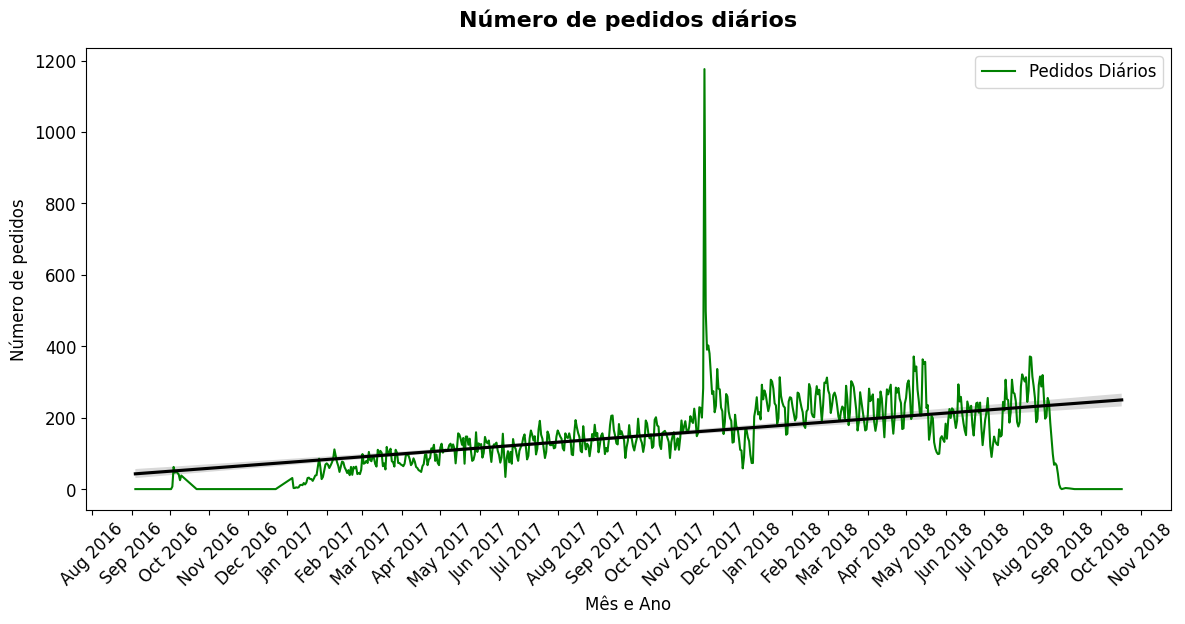

In [138]:
import matplotlib.dates as mdates

# Converter a coluna 'dia' para o formato de data
df['dia'] = pd.to_datetime(df['dia'])

# Configurações globais do matplotlib
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Converter as datas para valores numéricos para a linha de tendência
df['dia_num'] = mdates.date2num(df['dia'])

# Criar a figura e o eixo
plt.figure(figsize=(14, 6))

# Plotar o gráfico de linha com seaborn
ax = sns.lineplot(x='dia', y='count_pedidos', data=df, linestyle='-', color='green', label='Pedidos Diários')

# Adicionar a linha de tendência
sns.regplot(x='dia_num', y='count_pedidos', data=df, scatter=False, ax=ax, color='black', line_kws={'label': 'Tendência'})

# Ajustar os rótulos do eixo y e o título
ax.set_xlabel('Mês e Ano')
ax.set_ylabel('Número de pedidos')
ax.set_title('Número de pedidos diários', pad=15, fontsize=16, fontweight='bold', color='black')

# Ajustar os rótulos do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Mostrar a legenda
ax.legend()

# Mostrar o gráfico
plt.show()



**Verificando a distribuição dos pedidos ao longo da semana e das horas do dia.**

In [139]:
# Criar a consulta SQL para contagem de pedidos por dia e hora
encomendas_por_dia_e_hora = """
SELECT
    -- Dias da semana abreviados
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Seg'
        WHEN '2' THEN 'Ter'
        WHEN '3' THEN 'Qua'
        WHEN '4' THEN 'Qui'
        WHEN '5' THEN 'Sex'
        WHEN '6' THEN 'Sab'
        WHEN '0' THEN 'Dom'
        END AS dia_da_semana,
    -- Dias da semana como inteiro (Domingo=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS dia_da_semana_int,
    -- Hora do dia (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hora
FROM orders
"""

pd.read_sql_query(encomendas_por_dia_e_hora, db_connection)


,dia_da_semana,dia_da_semana_int,hora
0,Seg,1,10
1,Ter,2,20
2,Qua,3,8
3,Sab,6,19
4,Ter,2,21
...,...,...,...
99436,Qui,4,9
99437,Ter,2,12
99438,Dom,0,14
99439,Seg,1,21


In [140]:
# Gerar consultas SQL para contagem de pedidos por hora
contagem_pedidos_por_hora = ',\n    '.join([
    f'COUNT(CASE WHEN hora = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

pedidos_por_dia_da_semana_e_hora = f"""
WITH PedidosPorHora AS (
    {encomendas_por_dia_e_hora}
)

SELECT
    dia_da_semana,
    {contagem_pedidos_por_hora}
FROM PedidosPorHora
GROUP BY dia_da_semana_int
ORDER BY dia_da_semana_int
"""

In [141]:
print(pedidos_por_dia_da_semana_e_hora[591:])

ELECT
    dia_da_semana,
    COUNT(CASE WHEN hora = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hora = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hora = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hora = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hora = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hora = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hora = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hora = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hora = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hora = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hora = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hora = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hora = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hora = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hora = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hora = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hora = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hora = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hora = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN hora =

In [142]:
# Exibir a contagem total de pedidos por dia da semana e horário
df = pd.read_sql_query(pedidos_por_dia_da_semana_e_hora, db_connection)
df = df.set_index('dia_da_semana')
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
dia_da_semana,,,,,,,,,,,,,,,,,,,,,,,,
Dom,267,141,69,44,27,27,34,105,205,349,531,721,678,723,684,716,712,797,895,899,967,889,873,607
Seg,328,134,66,36,21,22,69,160,479,783,1035,1078,971,1027,1096,1079,1094,992,928,945,1027,1118,991,717
Ter,306,158,80,28,29,24,71,223,522,864,967,1056,898,1045,1124,1047,1081,967,877,924,988,1027,965,692
Qua,397,179,81,33,33,27,93,211,517,829,1042,1062,919,1029,1050,983,1040,967,852,848,904,963,878,615
Qui,355,167,75,39,31,28,85,220,502,758,984,960,983,986,977,928,1077,909,784,826,839,840,857,551
Sex,426,216,72,49,40,36,97,206,493,768,956,990,855,1002,961,979,974,817,723,784,738,726,702,512
Sab,315,175,67,43,25,24,53,106,249,434,662,711,691,706,677,722,697,701,710,756,730,654,550,429


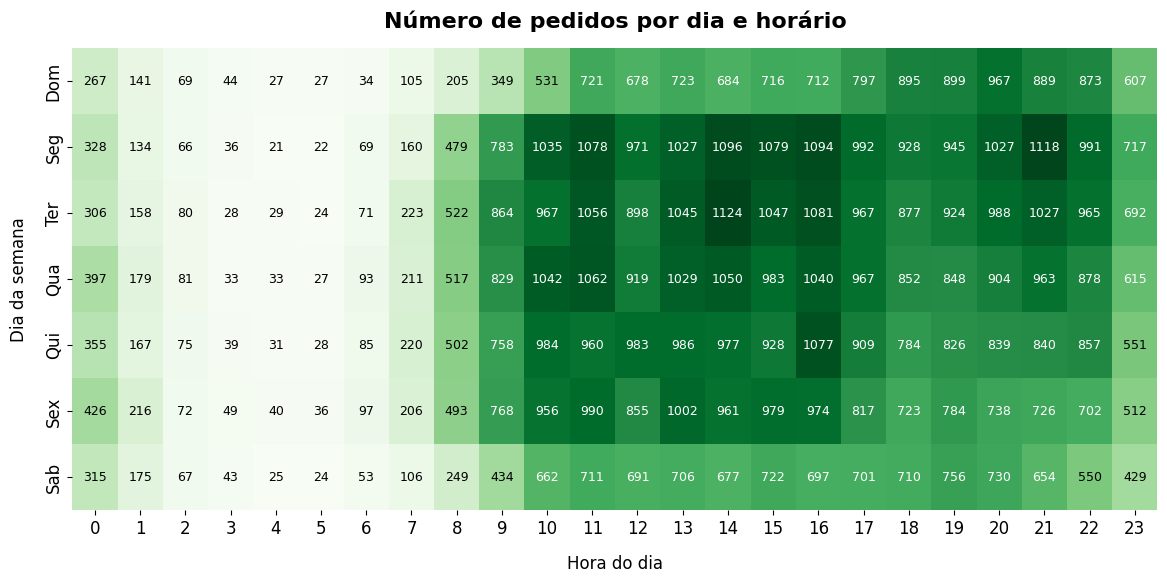

In [143]:
# Criar uma figura e um eixo com tamanho 14x6 polegadas
fig, ax = plt.subplots(figsize=(14, 6))

# Criar um mapa de calor (heatmap) usando o DataFrame df
sns.heatmap(df, cmap='Greens', cbar=False)

# Calcular a média de todas as encomendas no DataFrame
media_encomendas = df.mean().mean()

# Loop através das linhas do DataFrame
for i in range(len(df)):
    # Loop através das colunas do DataFrame
    for j in range(len(df.columns)):
        # Definir a cor do texto como branco se o valor for maior que a média, caso contrário, preto
        text_color = 'white' if df.iloc[i, j] > media_encomendas else 'black'
        # Adicionar o texto com o valor de cada célula no centro da célula
        ax.text(j + 0.5, i + 0.5, int(df.iloc[i, j]),
                color=text_color, fontsize=9, ha="center", va="center")

# Adicionar um título ao gráfico e rótulos ao eixo x e y
plt.title("Número de pedidos por dia e horário", pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel("Hora do dia", labelpad=12)
plt.ylabel("Dia da semana", labelpad=12)
plt.show()


O gráfico heatmap acima, mostra que a maioria dos pedidos foram realizados de segunda a sexta, em horário comercial, entre as 10:00h e 17:00h e de domingo a quarta-feira das 20:00h às 22:00h. Verificamos também um leve queda nas vendas por volta de meio dia.

Os picos de vendas ocorrem normalmente as segundas por volta das 14 e 21 horas, e as terças, também as 14 horas.

**Investigando a localização geográfica dos pedidos**

In [144]:
# Consulta SQL com as cinco primeiras linhas da tabela "customers"
consulta_simples('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [145]:
# Gerar consultas SQL para contagem de pedidos por cidade
pedidos_por_cidade = """
SELECT 
    customer_city AS cidade_cliente,
    UPPER(customer_city) AS cidade,
    COUNT(orders.order_id) AS contagem_pedidos_cidade
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY contagem_pedidos_cidade DESC
LIMIT 10
"""

pd.read_sql_query(pedidos_por_cidade, db_connection)

,cidade_cliente,cidade,contagem_pedidos_cidade
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


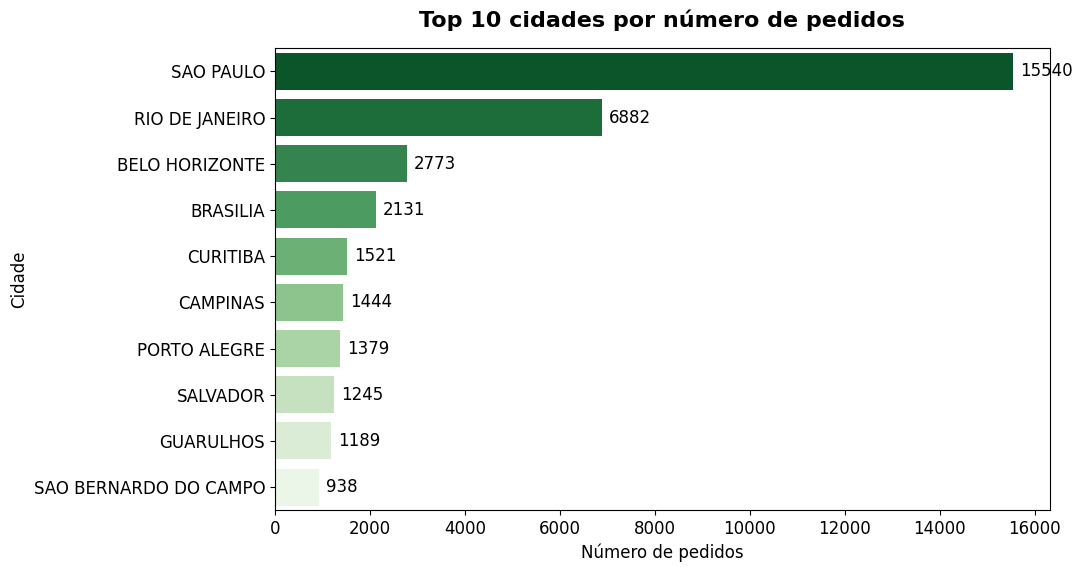

In [146]:
# Executar a consulta SQL e armazenar o resultado em um DataFrame
top_cities = pd.read_sql_query(pedidos_por_cidade, db_connection)

# Criar a figura e os eixos
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras horizontais com Seaborn
ax = sns.barplot(x='contagem_pedidos_cidade', y='cidade', data=top_cities, palette='Greens_r', orient='h')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 cidades por número de pedidos', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')

# Adicionar os valores no final das barras
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                va='center', xytext=(5, 0), textcoords='offset points')

# Exibir o gráfico
plt.show()

**Investigando os preços, valor médio do ticket e outras questões relacionadas a precificação.**

In [147]:
# Consulta SQL para obter as cinco primeiras linhas da tabela "order_items"
consulta_simples('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [148]:
# Consulta SQL para obter os preços dos itens e o valor do frete
consulta_simples('order_items', 5).iloc[:, 5:]

,price,freight_value
0,58.90,13.29
1,239.90,19.93
2,199.00,17.87
3,12.99,12.79
4,199.90,18.14


In [149]:
# Extrair estatísticas de preços através de sub consulta SQL
estatisticas_preco_pedido = """
SELECT
    MIN(preco_pedido) AS preco_min_pedido,
    ROUND(AVG(preco_pedido), 2) AS preco_medio_pedido,
    MAX(preco_pedido) AS preco_max_pedido
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS preco_pedido
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(estatisticas_preco_pedido, db_connection)

,preco_min_pedido,preco_medio_pedido,preco_max_pedido
0,9.59,160.58,13664.08


Ao analisarmos as estatísticas básicas dos preços, e compararmos o preço médio dos pedidos (R$ 160,58), o preço mínimo (R$ 9,59) e máximo (R$ 13.664,08), verificamos um desbalanceamento na distribuição dos valores através do que parece ser um ou mais outliers. O que resulta numa distribuição de cauda longa a direita que precisa ser investigada.

In [150]:
# Consulta SQL para obter o preço do item e o valor do frete
preco_produto_e_frete = """
SELECT
    orders.order_id,
    SUM(price) AS preco_produto,
    SUM(freight_value) AS custo_frete
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(preco_produto_e_frete, db_connection)
df

,order_id,preco_produto,custo_frete
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


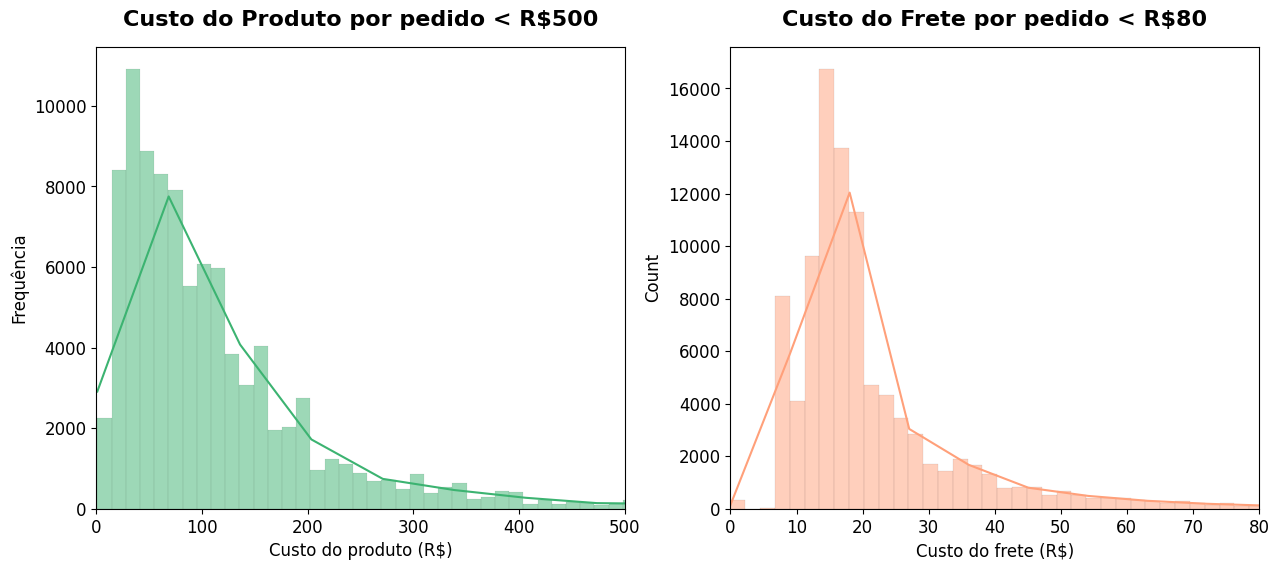

In [151]:
# Gráfico de dispersão de preço e frete
plt.figure(figsize=(15, 6))

# Gráfico do custo do produto
plt.subplot(1, 2, 1)
sns.histplot(df['preco_produto'], bins=1000, color='#3CB371', kde=True)
plt.title('Custo do Produto por pedido < R$500', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Custo do produto (R$)')
plt.ylabel('Frequência')
plt.xlim([0, 500])

# Gráfico do custo de frete
plt.subplot(1, 2, 2)
sns.histplot(df['custo_frete'], bins=800, color='#FFA07A', kde=True)
plt.title('Custo do Frete por pedido < R$80', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Custo do frete (R$)')
plt.xlim([0, 80])

# Mostrar os gráficos
plt.show()

Ao analisarmos os gráficos de histograma de preços e fretes, podemos concluir que a maior parte dos pedidos custam entre 15 e 150 reais e que o frete, tem a maioria dos seus valores entre 8 e 20 reais.

In [152]:
# Consulta SQL para obter os 10 produtos mais vendidos
consulta_simples('products', 10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,1000.00,30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.00,745.00,1.00,200.00,38.00,5.00,11.00
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.00,1272.00,4.00,18350.00,70.00,24.00,44.00
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.00,184.00,2.00,900.00,40.00,8.00,40.00
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.00,163.00,1.00,400.00,27.00,13.00,17.00
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.00,1156.00,1.00,600.00,17.00,10.00,12.00


In [153]:
# Consulta SQL para obter o ranking das categorias
ranking_categorias = """
SELECT
    product_category_name AS categoria,
    SUM(price) AS vendas,
    RANK() OVER (ORDER BY SUM(price) DESC) AS classificacao
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
WHERE order_status = 'delivered'
GROUP BY product_category_name
"""

pd.read_sql_query(ranking_categorias, db_connection)

,categoria,vendas,classificacao
0,beleza_saude,1233131.72,1
1,relogios_presentes,1166176.98,2
2,cama_mesa_banho,1023434.76,3
3,esporte_lazer,954852.55,4
4,informatica_acessorios,888724.61,5
...,...,...,...
69,flores,1110.04,70
70,casa_conforto_2,760.27,71
71,cds_dvds_musicais,730.00,72
72,fashion_roupa_infanto_juvenil,519.95,73


In [154]:
# Consulta SQL para obter o resumo de vendas por categoria
resumo_vendas_por_categoria = f"""
WITH CategoriasClassificadas AS (
    {ranking_categorias}
)
-- Top 15 categorias por vendas
SELECT
    categoria,
    vendas
FROM CategoriasClassificadas
WHERE classificacao <= 15
-- Outras categorias, agregadas
UNION ALL
SELECT
    'Outras categorias' AS categoria,
    SUM(vendas) AS vendas
FROM CategoriasClassificadas
WHERE classificacao > 15
"""

df = pd.read_sql_query(resumo_vendas_por_categoria, db_connection)
df

,categoria,vendas
0,beleza_saude,1233131.72
1,relogios_presentes,1166176.98
2,cama_mesa_banho,1023434.76
3,esporte_lazer,954852.55
4,informatica_acessorios,888724.61
...,...,...
11,bebes,400421.84
12,perfumaria,390144.65
13,telefonia,309860.23
14,moveis_escritorio,268154.31


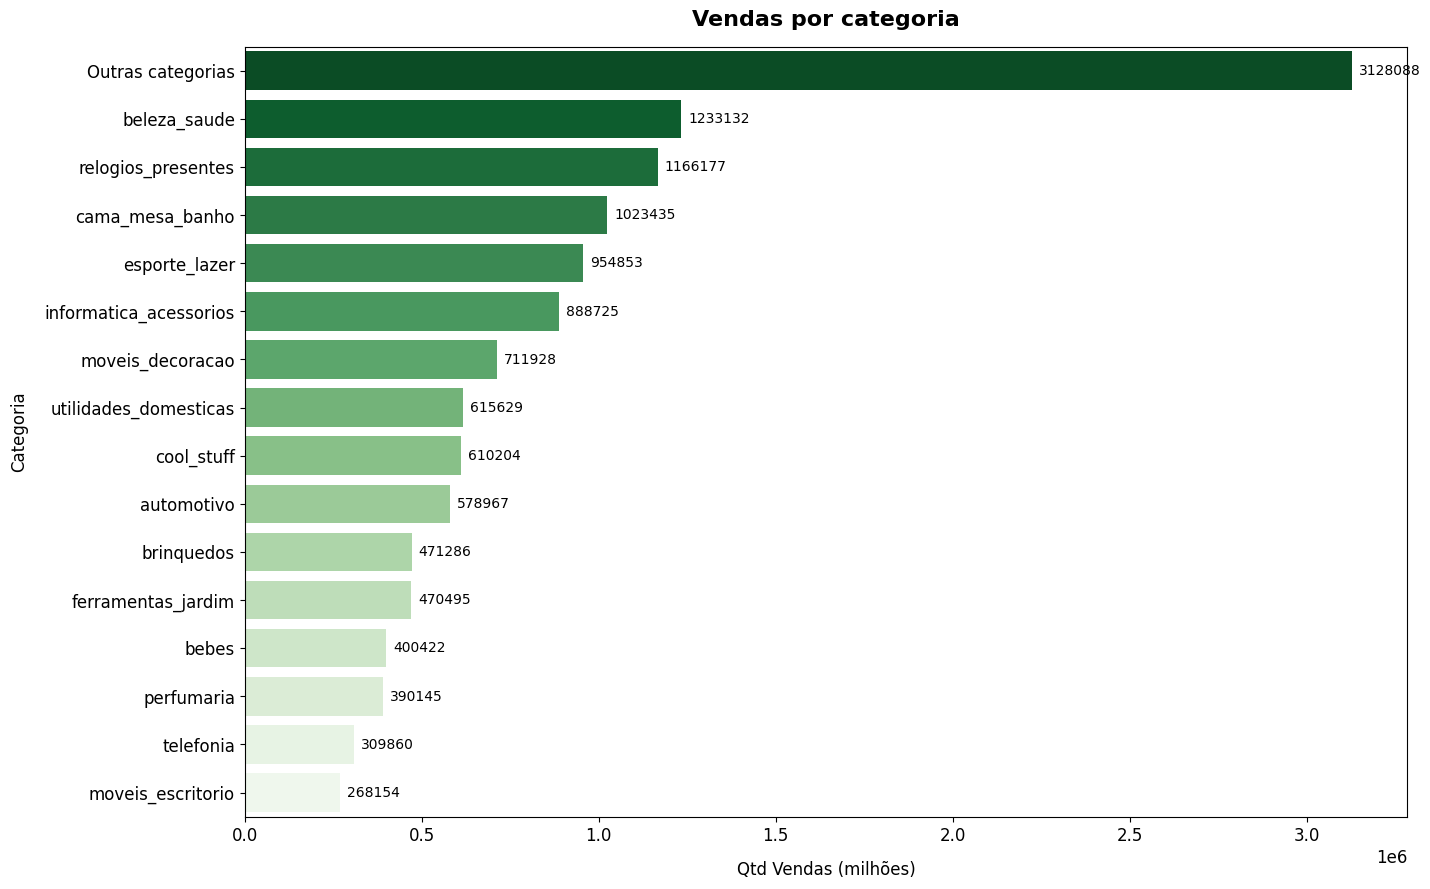

In [155]:
# Ordenar o DataFrame por vendas para um gráfico mais organizado
df_sorted = df.sort_values(by='vendas', ascending=False)
plt.figure(figsize=(15, 10))
# Criar o gráfico de barras horizontais
ax = sns.barplot(x='vendas', y='categoria', data=df_sorted, palette='Greens_r')

# Adicionar o título ao gráfico
plt.title('Vendas por categoria', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Qtd Vendas (milhões)', labelpad=12)
plt.ylabel('Categoria', labelpad=12)

# Adicionar valores às barras
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                va='center', xytext=(5, 0), textcoords='offset points',
                fontsize=10, color='Black')
    
plt.show()

In [156]:
# Definir top_15_categorias
top_15_categorias = tuple(categoria for categoria in df['categoria'] if categoria != 'Outras categorias')
top_15_categorias

('beleza_saude',
 'relogios_presentes',
 'cama_mesa_banho',
 'esporte_lazer',
 'informatica_acessorios',
 'moveis_decoracao',
 'utilidades_domesticas',
 'cool_stuff',
 'automotivo',
 'brinquedos',
 'ferramentas_jardim',
 'bebes',
 'perfumaria',
 'telefonia',
 'moveis_escritorio')

In [157]:
# Calcula o número da linha de cada produto dentro da sua categoria (ordenado pelo peso),
# a contagem total de produtos em cada categoria e cria um ranking top 15 usando SQL.
categorias_ordenadas = f"""
SELECT
    product_weight_g AS peso,
    product_category_name AS categoria,
    ROW_NUMBER() OVER(PARTITION BY product_category_name ORDER BY product_weight_g) AS categoria_linha_n,
    COUNT(*) OVER(PARTITION BY product_category_name) AS contagem_categoria
FROM
    products
    JOIN order_items USING (product_id)
WHERE
    product_category_name IN {top_15_categorias}
"""

df = pd.read_sql_query(categorias_ordenadas, db_connection)
df


,peso,categoria,categoria_linha_n,contagem_categoria
0,50.00,automotivo,1,4235
1,50.00,automotivo,2,4235
2,50.00,automotivo,3,4235
3,50.00,automotivo,4,4235
4,50.00,automotivo,5,4235
...,...,...,...,...
87752,30000.00,utilidades_domesticas,6960,6964
87753,30000.00,utilidades_domesticas,6961,6964
87754,30000.00,utilidades_domesticas,6962,6964
87755,30000.00,utilidades_domesticas,6963,6964


In [158]:
# Consulta SQL para obter a mediana do número de vendas por categoria
categorias_por_mediana = f"""
WITH CategoriasOrdenadas AS (
    -- Utiliza a consulta anterior para aplicar a consulta atual somente as categorias top 15
    {categorias_ordenadas}
)
SELECT categoria
FROM CategoriasOrdenadas
WHERE
    -- Selecione a linha do meio para calcular a mediana, quando o número de produtos for ímpar: 
    (contagem_categoria % 2 = 1 AND categoria_linha_n = (contagem_categoria + 1) / 2) OR
    -- Selecione as duas linha do meio para calcular a mediana, quando o número de produtos for par: 
    (contagem_categoria % 2 = 0 AND categoria_linha_n IN ((contagem_categoria / 2), (contagem_categoria / 2 + 1)))
GROUP BY categoria
ORDER BY AVG(peso)
"""

cat_p_mediana_df = pd.read_sql_query(categorias_por_mediana, db_connection)
cat_p_mediana_df

,categoria
0,telefonia
1,informatica_acessorios
2,relogios_presentes
3,beleza_saude
4,perfumaria
...,...
10,cama_mesa_banho
11,moveis_decoracao
12,cool_stuff
13,ferramentas_jardim


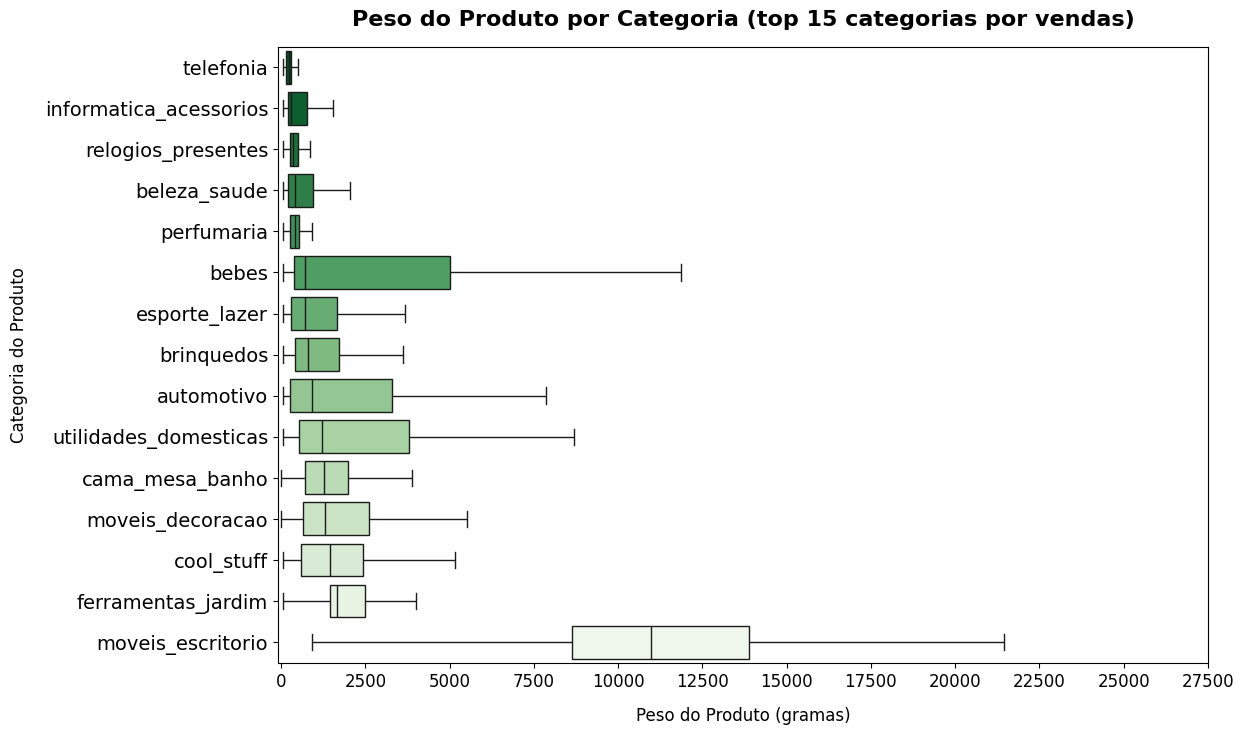

In [159]:
# Gráfico boxplot dos pesos das categorias top 15
plt.figure(figsize=(12, 8))
order = cat_p_mediana_df['categoria'].tolist()
sns.boxplot(x='peso', y='categoria', data=df, order=order, showfliers=False, palette='Greens_r')
plt.xlabel('Peso do Produto (gramas)', labelpad=12)
plt.ylabel('Categoria do Produto', labelpad=12)
plt.title('Peso do Produto por Categoria (top 15 categorias por vendas)', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

Pelo gráfico podemos entender a dinêmica dos custo do frete a partir do peso, já que ao analisarmos os dados, temos categorias como telefonia, informática, relógios, beleza e perfumaria e que vendem bastante, com um custo de frete mais baixo pois são encomendas com peso em média até 2kg. Já 'móveis e ecritório' têm em média de 8 a 14kg o que pode ocasionar um custo alto do frete e um impacto nas vendas.

In [160]:
consulta_simples('sellers', 100)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
95,cda598c48d7c614bc1cad7d8ff6f0010,15137,mirassol,SP
96,d4910f1cdcfdabd48d6b316e395d4a23,9190,santo andre,SP
97,709e16e2b25c7474d980076c6bfc4806,16200,birigui,SP
98,9dc79dd988ac42f4d56c340d7048420a,3569,sao paulo,SP


In [161]:
consulta_simples('geolocation', 10)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.55,-46.64,sao paulo,SP
1,1046,-23.55,-46.64,sao paulo,SP
2,1046,-23.55,-46.64,sao paulo,SP
3,1041,-23.54,-46.64,sao paulo,SP
4,1035,-23.54,-46.64,sao paulo,SP
5,1012,-23.55,-46.64,são paulo,SP
6,1047,-23.55,-46.64,sao paulo,SP
7,1013,-23.55,-46.63,sao paulo,SP
8,1029,-23.54,-46.63,sao paulo,SP
9,1011,-23.55,-46.64,sao paulo,SP


Podemos ver que na base de dados, temos a geolocalização de todos os pedidos. Podemos construir um mapa para visualizar de maneira mais fácil a distribuição geográfica das vendas.

Capiturando as latitudes e longitudes para serem utilizadas em um futuro Mapa

In [162]:
import unicodedata

# Definir a consulta SQL
geolocation_query = """
SELECT
    geolocation_lat,
    geolocation_lng,
    geolocation_city,
    geolocation_state
FROM geolocation
"""

# Executar a consulta e criar o DataFrame
df_loc_map = pd.read_sql_query(geolocation_query, db_connection)

# Função para remover acentuação de um texto
def remove_accent(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

# Normalizar a coluna geolocation_city removendo acentuação
df_loc_map['geolocation_city_normalized'] = df_loc_map['geolocation_city'].apply(remove_accent)

# Eliminar linhas com valores duplicados em geolocation_city_normalized
df_loc_map = df_loc_map.drop_duplicates(subset=['geolocation_city_normalized'])

# Eliminar linhas com valores duplicados simultaneamente em geolocation_lat e geolocation_lng
df_loc_map = df_loc_map.drop_duplicates(subset=['geolocation_lat', 'geolocation_lng'])

# Remover a coluna temporária usada para normalização
df_loc_map = df_loc_map.drop(columns=['geolocation_city_normalized'])

# Exibir as primeiras 5 linhas do DataFrame resultante
df_loc_map.head(5)



,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,-23.55,-46.64,sao paulo,SP
10166,-23.56,-46.66,sao bernardo do campo,SP
50999,-23.22,-46.86,jundiaí,SP
71908,-23.57,-46.65,taboão da serra,SP
80754,-23.62,-46.62,sãopaulo,SP


In [163]:
df_loc_map.shape

(5966, 4)

In [164]:
df_loc_map['geolocation_city'].unique()

array(['sao paulo', 'sao bernardo do campo', 'jundiaí', ...,
       'floriano peixoto', 'erebango', 'santa cecilia do sul'],
      dtype=object)

In [165]:
#import folium

In [166]:
# mapa = folium.Map(location=[-23.5489, -46.6388])
# for local, lat, lng in zip(df_loc_map['geolocation_city'], df_loc_map['geolocation_lat'], df_loc_map['geolocation_lng']):
#     folium.Marker([lat, lng], popup=local).add_to(mapa)

In [167]:
# mapa.add_child(folium.LatLngPopup())
# folium.Marker(
#     location=[-23.5503099, -46.6342009], 
#     popup = 'Praça da Sé',
#     tooltip = 'Click Aqui',
#     icon = folium.Icon(color='green')
# ).add_to(mapa)